In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import seaborn as sns
import datetime

            cannonsville    pepacton   neversink   aggregate
datetime                                                    
2000-06-01    188.848265  282.792928  237.290438  708.931631
2000-06-02    195.814163  403.451255   94.903337  694.168755
2000-06-03    295.638459  257.101867  138.424816  691.165142
2000-06-04    295.638459  286.755214  140.405827  722.799500
2000-06-05    295.638459  443.010448   92.922326  831.571233
...                  ...         ...         ...         ...
2010-05-27    271.928673  197.731245    0.000000  469.659918
2010-05-28    295.638459  319.412174    0.000000  615.050632
2010-05-29    295.638459  345.103235    0.000000  640.741693
2010-05-30    295.638459  345.103235    0.000000  640.741693
2010-05-31    295.638459  345.103235    0.000000  640.741693

[3652 rows x 4 columns]


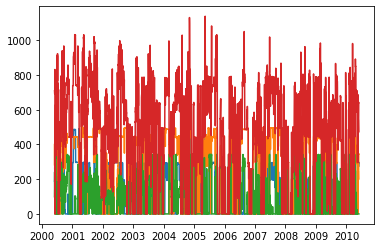

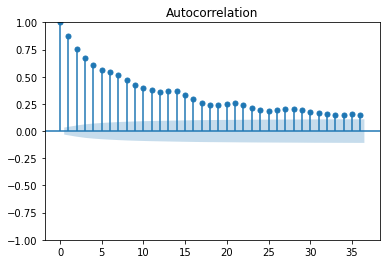

In [2]:
### read in NYC diversion data
nyc = pd.read_csv('input_data/deliveryNYC_WEAP_23Aug2022_gridmet.csv', index_col=0)
nyc.index = pd.to_datetime(nyc.index)
nyc = nyc.loc[nyc.index >= datetime.datetime(2000,6,1)]

print(nyc)

plt.plot(nyc)

_ = tsaplots.plot_acf(nyc['aggregate'])

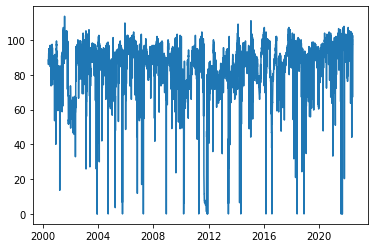

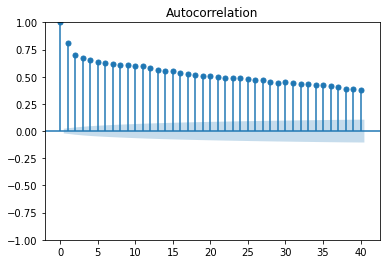

In [3]:
### read in NJ diversion data
nj = pd.read_csv('input_data/deliveryNJ_WEAP_23Aug2022_gridmet.csv', index_col=0)
nj.index = pd.to_datetime(nj.index)
nj = nj.loc[nj.index >= datetime.datetime(2000,6,1)]
plt.plot(nj)

_ = tsaplots.plot_acf(nj['D_R_Canal'])

In [4]:
# stor = pd.read_csv('input_data/storageObs_WEAP_23Aug2022_gridmet.csv', index_col=0)
# stor.index = pd.to_datetime(stor.index)
# stor = stor.loc[stor.index >= datetime.datetime(2000,6,1)]
# plt.plot(stor)

# stor['aggregate'] = stor['cannonsville'] + stor['pepacton'] + stor['neversink']



In [5]:
### read in total gaged flow to NYC reservoirs
flow = pd.read_csv('input_data/catchment_inflow_obs_pub.csv', index_col=0)

flow.index = pd.to_datetime(flow.index)
flow = flow.loc[np.logical_and(flow.index >= datetime.datetime(2000,6,1), flow.index <= datetime.datetime(2010, 5,31))]

assert np.all(flow.index == nyc.index)

/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/alh/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


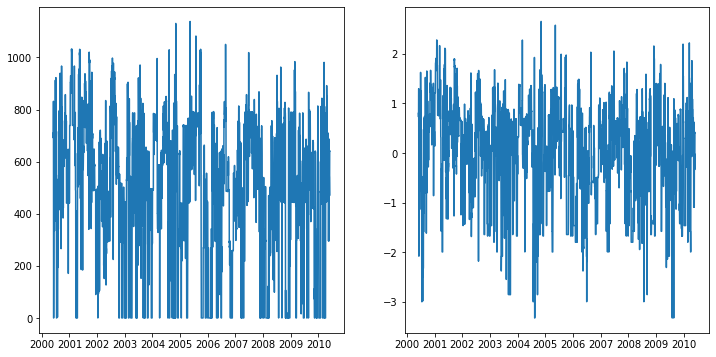

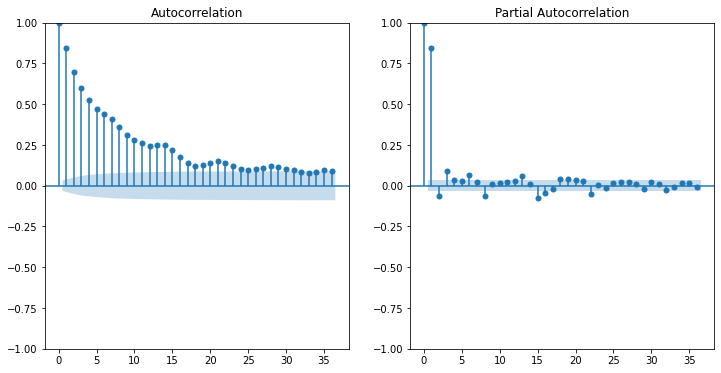

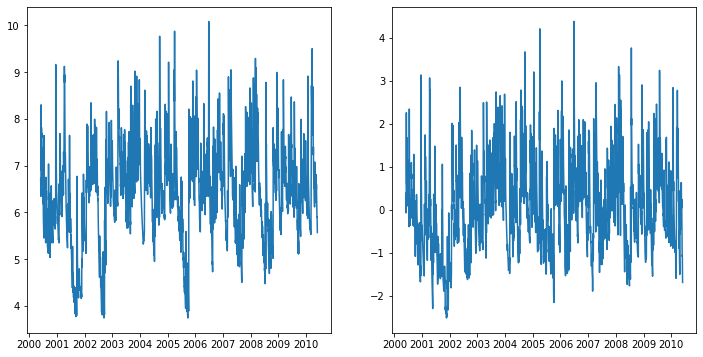

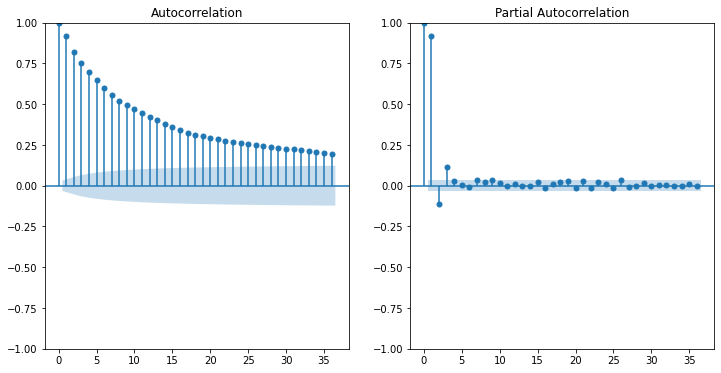

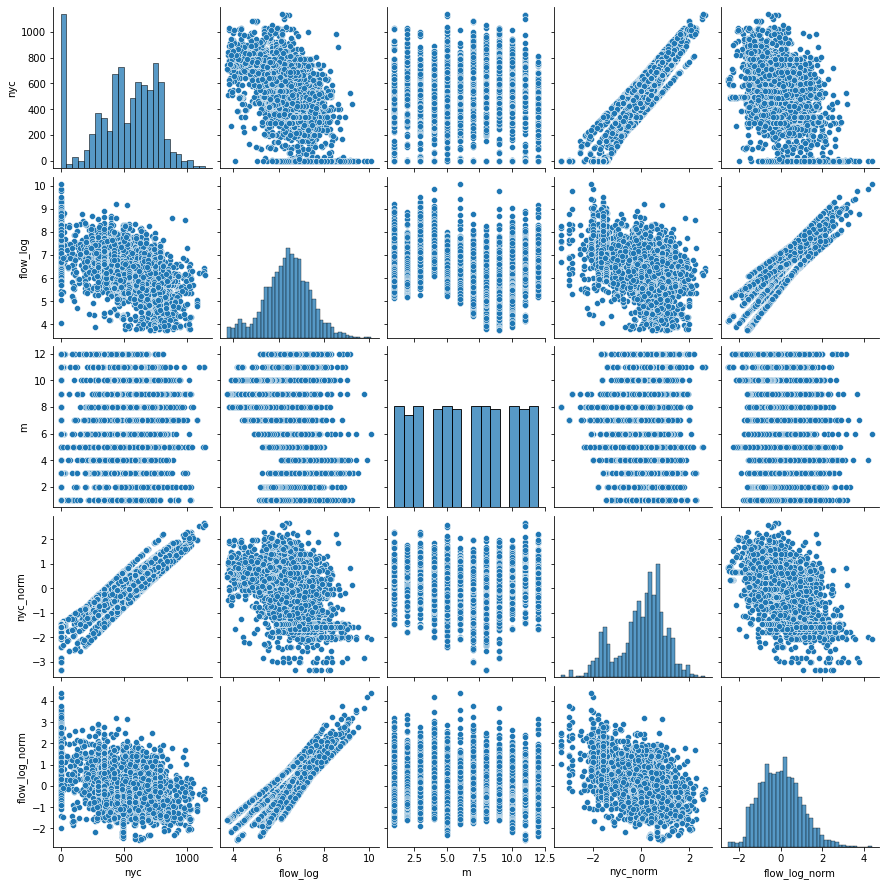

In [6]:
### build ARIMA model of normalized nyc deliveries with month and normalized log flow as exogenous predictors
df = pd.DataFrame({'nyc':nyc['aggregate'], 'flow_log':np.log(flow[['cannonsville','pepacton','neversink']].sum(axis=1)), 'm':nyc.index.month}, index=nyc.index)

# ### whiten deliveries & log flow by month
df['nyc_norm'] = 0.
nyc_means = {}
nyc_stds = {}
for m in range(1,13):
    nyc_means[m] = df['nyc'].loc[df['m'] == m].mean()
    nyc_stds[m] = df['nyc'].loc[df['m'] == m].std()
    df['nyc_norm'].loc[df['m'] == m] = (df['nyc'].loc[df['m'] == m] - nyc_means[m]) / nyc_stds[m]
df['flow_log_norm'] = 0.
flow_means = {}
flow_stds = {}
for m in range(1,13):
    flow_means[m] = df['flow_log'].loc[df['m'] == m].mean()
    flow_stds[m] = df['flow_log'].loc[df['m'] == m].std()
    df['flow_log_norm'].loc[df['m'] == m] = (df['flow_log'].loc[df['m'] == m] - flow_means[m]) / flow_stds[m]

fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(df['nyc'])
axs[1].plot(df['nyc_norm'])

fig, axs = plt.subplots(1,2,figsize=(12,6))
_ = tsaplots.plot_acf(df['nyc_norm'], ax=axs[0])
_ = tsaplots.plot_pacf(df['nyc_norm'], ax=axs[1])

fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].plot(df['flow_log'])
axs[1].plot(df['flow_log_norm'])

fig, axs = plt.subplots(1,2,figsize=(12,6))
_ = tsaplots.plot_acf(df['flow_log_norm'], ax=axs[0])
_ = tsaplots.plot_pacf(df['flow_log_norm'], ax=axs[1])

sns.pairplot(df)



In [7]:
# ### difference the model to improve ARMA fit (ie ARIMA with d=1)

# # ### whiten deliveries & log flow by month
# df['nyc_norm_diff'] = 0.
# df['nyc_norm_diff'].iloc[1:] = df['nyc_norm'].iloc[1:] - df['nyc_norm'].iloc[:-1].values

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].plot(df['nyc'])
# axs[1].plot(df['nyc_norm_diff'])

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# _ = tsaplots.plot_acf(df['nyc_norm_diff'], ax=axs[0])
# _ = tsaplots.plot_pacf(df['nyc_norm_diff'], ax=axs[1])






In [8]:
# ### fit arima model now (remember we already differenced)
# from statsmodels.tsa.arima.model import ARIMA

# # arima_mod = ARIMA(df['nyc_norm'], exog=df[['m','flow_log_norm']], order=(3,1,3), seasonal_order=(1,0,1,7))
# # arima_mod = ARIMA(df['nyc_norm_diff'], exog=df[['flow_log_norm']], order=(2,0,1), seasonal_order=(1,0,1,7))
# # arima_mod = ARIMA(df['nyc_norm_diff'], order=(2,0,1), seasonal_order=(1,0,1,7))
# arima_mod = ARIMA(df['nyc_norm_diff'], exog=df[['flow_log_norm']], order=(3,0,0), seasonal_order=(1,0,0,7))


# arima_res = arima_mod.fit()
# print(arima_res.summary())

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# _= tsaplots.plot_acf(arima_res.resid, ax=axs[0])
# _= tsaplots.plot_pacf(arima_res.resid, ax=axs[1])

In [9]:
# ### now try simulating alternative diversion scenarios from fitted arima. note I was getting weird results with "simulate" above.

# ### first resample residuals from empirical residuals
# resid_samp = np.random.choice(arima_res.resid, size=len(arima_res.resid), replace=True)

# ### now simulate ARMA process
# df['nyc_norm_diff_pred'] = df['nyc_norm_diff']

# for i in range(7, df.shape[0]):
#     zero_norm = -nyc_means[df['m'].iloc[i]]/nyc_stds[df['m'].iloc[i]]
# #     df['nyc_norm_pred'].iloc[i] = max(arima_res.params[0] + \
# #                                       arima_res.params[1] * df['flow_log_norm'].iloc[i] + \
# #                                       arima_res.params[2] * df['nyc_norm_pred'].iloc[i-1] + \
# #                                       arima_res.params[3] * df['nyc_norm_pred'].iloc[i-2] + \
# #                                       arima_res.params[4] * df['nyc_norm_pred'].iloc[i-3] + \
# #                                       arima_res.params[5] * resid_samp[i-1] + \
# #                                       arima_res.params[6] * df['nyc_norm_pred'].iloc[i-7] + \
# #                                       arima_res.params[7] * resid_samp[i-7] + \
# #                                       resid_samp[i], 
# #                                       zero_norm)

# #     df['nyc_norm_diff_pred'].iloc[i] = arima_res.params[0] + \
# #                                       arima_res.params[1] * df['nyc_norm_diff_pred'].iloc[i-1] + \
# #                                       arima_res.params[2] * df['nyc_norm_diff_pred'].iloc[i-2] + \
# #                                       arima_res.params[3] * resid_samp[i-1] + \
# #                                       arima_res.params[4] * df['nyc_norm_diff_pred'].iloc[i-7] + \
# #                                       arima_res.params[5] * resid_samp[i-7] + \
# #                                       resid_samp[i]

#     df['nyc_norm_diff_pred'].iloc[i] = max(arima_res.params[0] + \
#                                       arima_res.params[1] * df['flow_log_norm'].iloc[i] + \
#                                       arima_res.params[2] * df['nyc_norm_diff_pred'].iloc[i-1] + \
#                                       arima_res.params[3] * df['nyc_norm_diff_pred'].iloc[i-2] + \
#                                       arima_res.params[4] * df['nyc_norm_diff_pred'].iloc[i-3] + \
#                                       arima_res.params[5] * df['nyc_norm_diff_pred'].iloc[i-7] + \
#                                       resid_samp[i], 
#                                       zero_norm)

# # ### apply integration, but dont allow to drop below 0
# df['nyc_norm_pred'] = 0.
# df['nyc_norm_pred'].iloc[0] = df['nyc_norm'].iloc[0]
# for i in range(1,df.shape[0]):
#     zero_norm = -nyc_means[df['m'].iloc[i]]/nyc_stds[df['m'].iloc[i]]
#     df['nyc_norm_pred'].iloc[i] = max(df['nyc_norm_pred'].iloc[i-1] + df['nyc_norm_diff_pred'].iloc[i], zero_norm)


# ### rescale
# df['nyc_pred'] = [v * nyc_stds[m] + nyc_means[m] for v,m in zip(df['nyc_norm_pred'],df['m'])]

In [10]:
# df

In [11]:
# ### compare predicted & observed deliveries
# alpha=0.7
# plt.figure(figsize=(12,5))
# plt.plot(df['nyc'], alpha=alpha)
# plt.plot(df['nyc_pred'], alpha=alpha)
# plt.legend()

# plt.figure(figsize=(12,5))
# plt.plot(df['nyc'].rolling(30).mean(), alpha=alpha)
# plt.plot(df['nyc_pred'].rolling(30).mean(), alpha=alpha)
# plt.legend()

/home/alh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/alh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/alh/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                    SARIMAX Results                                    
Dep. Variable:                        nyc_norm   No. Observations:                 3652
Model:             ARIMA(3, 0, 0)x(1, 0, 0, 7)   Log Likelihood               -2763.021
Date:                         Mon, 10 Apr 2023   AIC                           5540.043
Time:                                 10:44:18   BIC                           5583.464
Sample:                             06-01-2000   HQIC                          5555.506
                                  - 05-31-2010                                         
Covariance Type:                           opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.049      0.026      0.980      -0.095       0.098
flow_log_norm    -0.2671      0.015    -17.248    

/home/alh/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


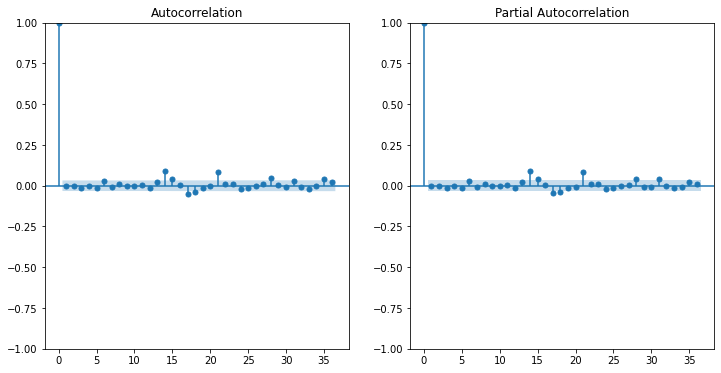

In [21]:
### retry with no differencing, something weird was happening
from statsmodels.tsa.arima.model import ARIMA

# arima_mod = ARIMA(df['nyc_norm'], exog=df['flow_log_norm'], order=(2,0,1), seasonal_order=(1,0,1,7))
arima_mod = ARIMA(df['nyc_norm'], exog=df['flow_log_norm'], order=(3,0,0), seasonal_order=(1,0,0,7))



arima_res = arima_mod.fit()
print(arima_res.summary())

fig, axs = plt.subplots(1,2,figsize=(12,6))
_= tsaplots.plot_acf(arima_res.resid, ax=axs[0])
_= tsaplots.plot_pacf(arima_res.resid, ax=axs[1])

In [22]:
arima_res.params

const            0.001266
flow_log_norm   -0.267123
ar.L1            0.861261
ar.L2           -0.125275
ar.L3            0.064313
ar.S.L7          0.099700
sigma2           0.265787
dtype: float64

In [23]:
### now try simulating alternative diversion scenarios from fitted arima. note I was getting weird results with "simulate" above.

### first resample residuals from empirical residuals
resid_samp = np.random.choice(arima_res.resid, size=len(arima_res.resid), replace=True)
# resid_samp = np.random.normal(0, np.sqrt(arima_res.params[-1]), size=len(arima_res.resid))


### now simulate ARMA process
df['nyc_norm_pred'] = df['nyc_norm']

for i in range(7, df.shape[0]):
    zero_norm = -nyc_means[df['m'].iloc[i]]/nyc_stds[df['m'].iloc[i]]
#     df['nyc_norm_pred'].iloc[i] = max(arima_res.params[0] + \
#                                       arima_res.params[1] * df['flow_log_norm'].iloc[i] + \
#                                       arima_res.params[2] * df['nyc_norm_pred'].iloc[i-1] + \
#                                       arima_res.params[3] * df['nyc_norm_pred'].iloc[i-2] + \
#                                       arima_res.params[4] * resid_samp[i-1] + \
#                                       arima_res.params[5] * df['nyc_norm_pred'].iloc[i-7] + \
#                                       arima_res.params[6] * resid_samp[i-7] + \
#                                       resid_samp[i], 
#                                       zero_norm)
    
    df['nyc_norm_pred'].iloc[i] = max(arima_res.params[0] + \
                                  arima_res.params[1] * df['flow_log_norm'].iloc[i] + \
                                  arima_res.params[2] * df['nyc_norm_pred'].iloc[i-1] + \
                                  arima_res.params[3] * df['nyc_norm_pred'].iloc[i-2] + \
                                  arima_res.params[4] * df['nyc_norm_pred'].iloc[i-3] + \
                                  arima_res.params[5] * df['nyc_norm_pred'].iloc[i-7] + \
                                  resid_samp[i], 
                                  zero_norm)


### rescale
df['nyc_pred'] = [v * nyc_stds[m] + nyc_means[m] for v,m in zip(df['nyc_norm_pred'],df['m'])]

/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [24]:
df.iloc[:20]

,nyc,flow_log,m,nyc_norm,flow_log_norm,nyc_norm_pred,nyc_pred
datetime,,,,,,,
2000-06-01,708.931631,6.723408,6,0.798032,0.377175,0.798032,708.931631
2000-06-02,694.168755,6.617789,6,0.738078,0.251503,0.738078,694.168755
2000-06-03,691.165142,6.678921,6,0.725880,0.324242,0.725880,691.165142
2000-06-04,722.799500,6.434430,6,0.854352,0.033335,0.854352,722.799500
2000-06-05,831.571233,6.340986,6,1.296089,-0.077850,1.296089,831.571233
2000-06-06,174.980079,7.546097,6,-1.370422,1.356049,-1.370422,174.980079
2000-06-07,0.000000,8.299186,6,-2.081042,2.252111,-2.081042,0.000000
2000-06-08,0.000000,7.601528,6,-2.081042,1.422004,-2.081042,0.000000
2000-06-09,249.177296,7.286459,6,-1.069097,1.047120,-1.878219,49.942144


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


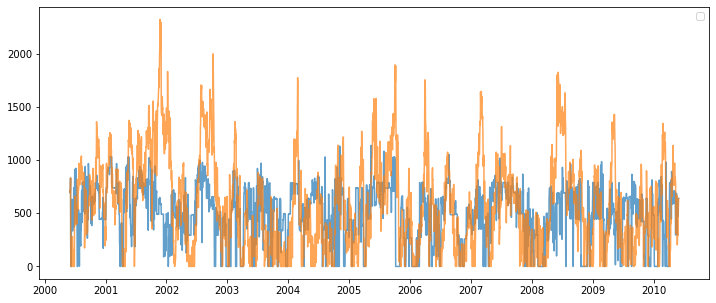

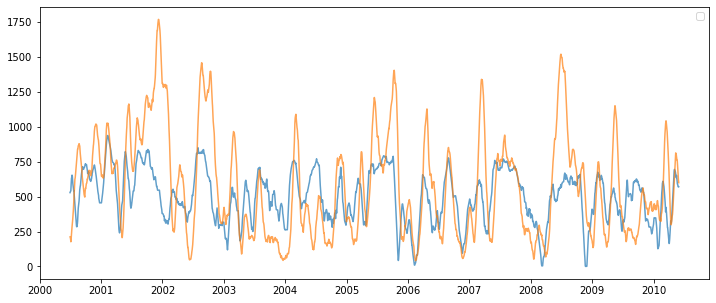

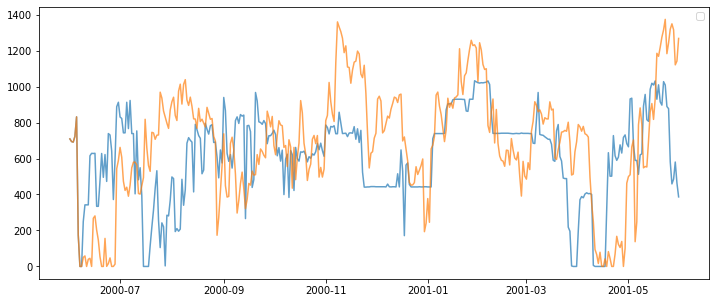

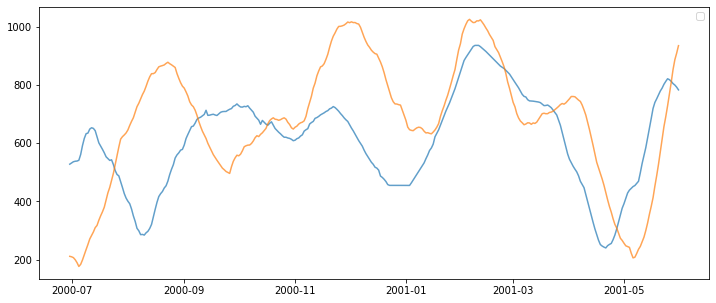

In [25]:
### compare predicted & observed deliveries
alpha=0.7
plt.figure(figsize=(12,5))
plt.plot(df['nyc'], alpha=alpha)
plt.plot(df['nyc_pred'], alpha=alpha)
plt.legend()

plt.figure(figsize=(12,5))
plt.plot(df['nyc'].rolling(30).mean(), alpha=alpha)
plt.plot(df['nyc_pred'].rolling(30).mean(), alpha=alpha)
plt.legend()

plt.figure(figsize=(12,5))
plt.plot(df['nyc'].iloc[:365], alpha=alpha)
plt.plot(df['nyc_pred'].iloc[:365], alpha=alpha)
plt.legend()

plt.figure(figsize=(12,5))
plt.plot(df['nyc'].iloc[:365].rolling(30).mean(), alpha=alpha)
plt.plot(df['nyc_pred'].iloc[:365].rolling(30).mean(), alpha=alpha)
plt.legend()

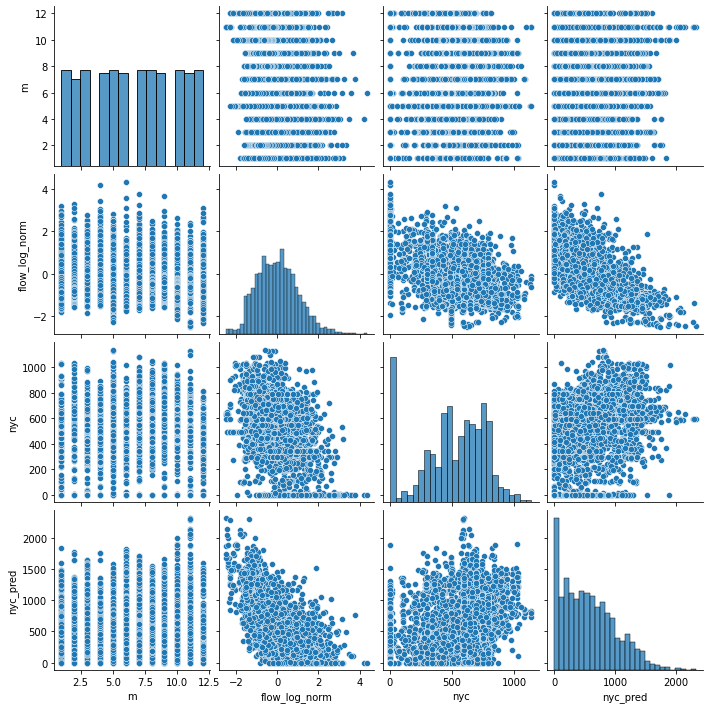

In [26]:
sns.pairplot(df, vars=['m','flow_log_norm','nyc','nyc_pred'])